In [1]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'class_object'
proxy = 'nwot'
data = dfs[dataset]

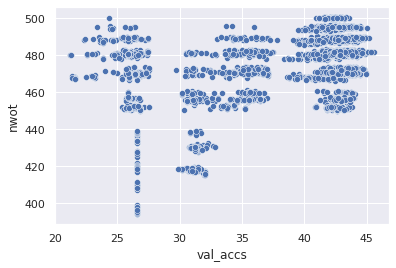

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
#plt.ylim(-1, 300)
#plt_ylim(proxy)
plt.show()

In [19]:
from zc_combine.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3}
ops = parse_ops_nb201(data)
count_all_ops(data, ops, count_set)

In [6]:
# TNB101_micro op names and edge indices to edges for convenience
# Op indices for zero and identity are 0, 1, in NB201 they are 1, 0
OP_NAMES = ["Zero", "Identity", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['none', 'skip_connect', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

In [7]:
edge_map = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))
edge_map = {val: i for i, val in enumerate(edge_map)}

def edge(op_list, i, j):
    return op_list[edge_map[(i, j)]]

def zero_outgoing(net):
    for node in [2, 3]:
        inactive = all([(edge(net, i, node) == 1) for i in range(1, node)])
        if not inactive:
            continue
        for j in range(node + 1, 5):
            net[edge_map[(node, j)]] = 1
    return net


def zero_ingoing(net):
    for node in [3, 2]:
        inactive = all([(edge(net, node, j) == 1) for j in range(node + 1, 5)])
        if not inactive:
            continue
        for i in range(1, node):
            net[edge_map[(i, node)]] = 1
    return net


for i, net in enumerate(data['net']):
    net = [int(i) for i in net.strip('()').split(',')]
    net1 = zero_outgoing(net)
    net2 = zero_ingoing(net1)

    net = f"({', '.join([str(i) for i in net2])})"
    idx = data.index[i]
    data.loc[idx, 'new_net'] = net

In [22]:
ok_data = data[data['new_net'] == data['net']]
len(ok_data), len(data)

(2128, 4096)

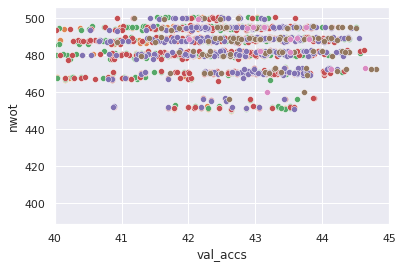

In [26]:
from zc_combine.operations import plot_clouds

plot_clouds(ok_data, (1, 3), proxy, vmax=7)
#plt.ylim(-32.8, -31.8)
plt.xlim(40, 45)
#plt_ylim(proxy)
plt.show()

In [17]:
ok_data

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,...,snip,zen,epe_nas,synflow,random,rank,"(2,)","(3,)","(2, 3)",new_net
0,"(2, 3, 2, 3, 2, 3)",42.759754,4.458780,4662.880768,74.508804,-2.955261,-32.010446,1265.389038,500.717764,22.391940,...,656.970154,140.918808,451.375314,108.596648,1196,1432.0,3,3,6,"(2, 3, 2, 3, 2, 3)"
1,"(3, 1, 1, 2, 1, 2)",42.316879,0.685677,1719.888384,20.240038,-0.260801,-32.011969,730.687561,482.160494,7.911300,...,179.962784,80.168358,838.104942,80.325202,2254,1945.0,2,1,3,"(3, 1, 1, 2, 1, 2)"
2,"(0, 0, 2, 1, 2, 3)",31.085789,0.031169,1971.087872,2.674740,-0.012566,-33.342949,771.542419,418.033056,9.631620,...,12.530449,8.850382,223.298620,19.618938,3954,3445.5,2,1,3,"(0, 0, 2, 1, 2, 3)"
3,"(3, 3, 3, 3, 0, 0)",42.411427,0.249479,5463.075328,6.833540,0.003300,-32.012307,828.335632,488.500280,26.117252,...,57.221085,103.818619,823.921237,49.518576,3231,1861.0,0,4,4,"(3, 3, 3, 3, 0, 0)"
6,"(2, 1, 1, 3, 2, 3)",42.187500,1.369568,3232.393728,35.011379,0.639004,-32.009180,948.673401,489.361654,15.584132,...,334.091278,105.183723,616.829033,84.024537,1087,2062.0,2,2,4,"(2, 1, 1, 3, 2, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4088,"(0, 0, 0, 1, 0, 3)",30.976315,0.029432,1630.431744,2.210698,0.014141,-33.781049,334.351288,417.671527,7.917444,...,9.753294,10.973930,244.477003,19.650658,1550,3482.0,0,1,1,"(0, 0, 0, 1, 0, 3)"
4090,"(3, 3, 3, 1, 0, 2)",44.153065,0.909518,4373.244416,30.881533,-0.187820,-32.012418,948.201050,489.694640,21.023620,...,299.446136,113.669861,572.671152,117.801916,706,124.0,1,3,4,"(3, 3, 3, 1, 0, 2)"
4092,"(2, 2, 2, 0, 3, 3)",39.450638,6.198863,3577.965056,86.561401,-2.336487,-32.019332,1067.456665,493.603007,17.643652,...,687.399597,109.258804,452.517163,107.955520,1633,2851.5,3,2,5,"(2, 2, 2, 0, 3, 3)"
4094,"(3, 0, 1, 0, 2, 2)",41.197254,4.259406,1718.741504,43.316685,-1.310471,-32.011036,650.607178,478.166322,7.909508,...,332.975159,65.601761,735.741729,85.261094,3021,2632.5,2,1,3,"(3, 0, 1, 0, 2, 2)"


Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

But, accuracy seems to depend on it a bit!

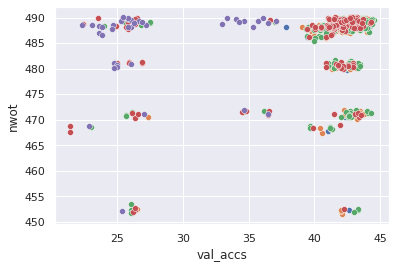

In [16]:
zoom = 4

data_zoom = ok_data[ok_data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=7)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

Similar to NAS-Bench-201, there is some regularity in different score values:
- nets in the lowest cluster have inactive edges (1,2) and (1,3)
- nets in the second lowest cluster have inactive edge (1,2)
- nets in the second highest cluster have either inactive edge (1,2) and no other inactive, or have inactive both (1,3) and (1,4)
- nets in the highest cluster never have the highest edge inactive

In [42]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_0 = get_op_array(filter_by_range(data_zoom, proxy, 450, 465))
ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 465, 475))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 475, 483))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 483, 500))

In [44]:
np.unique(ops_0[:, 0]), np.unique(ops_0[:, 1])

(array([0]), array([0]))

In [26]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0]), array([1, 2, 3]))

In [35]:
ops_2[ops_2[:, 0] != 0]

array([[3, 0, 0, 2, 3, 2],
       [2, 0, 0, 3, 2, 2],
       [3, 0, 0, 3, 3, 2],
       [3, 0, 0, 2, 3, 3],
       [2, 0, 0, 3, 3, 2],
       [2, 0, 0, 2, 2, 3],
       [2, 0, 0, 3, 2, 3],
       [3, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 3, 3],
       [3, 0, 0, 3, 3, 3],
       [2, 0, 0, 3, 3, 3],
       [2, 0, 0, 2, 3, 2],
       [3, 0, 0, 3, 2, 2],
       [3, 0, 0, 2, 2, 3],
       [3, 0, 0, 3, 2, 3]])

In [27]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 2, 3]), array([0, 2, 3]))

In [28]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([1, 2, 3]), array([0, 1, 2, 3]))

## Conclusion
NASWOT score has problems on other datasets than CIFAR-10 as well.